Data Overview:

In [237]:
import pandas
import numpy
import re
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Modify this to point to your data.
unique_data = pandas.read_csv('data.txt', sep = "\t")
unique_data

,label,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10
0,2,906 m^3,0.9669,sANTA cLARITA,"Fremont, Santa Ana",fabrice,0.5996,220.0,-49,951 N,LISE,1038
1,5,477 m^3,0.3338,San Francisco,San Francisco,Sam,0.152,237.0,581,450 N,Eriq,337
2,0,861 m^3,0.6165,San Diego,"Fresno, Stockton",Eriq,0.6312,632.0,36,910 N,Andrew,-50
3,0,1100 m^3,0.4111,Sacramento,"Stockton, Fresno",Michael,0.4227,386.0,304,547 N,Vani,225
4,2,925 m^3,0.7413,Santa Ana,Santa Ana,Fabrice,0.6331,519.0,-158,1005 N,Lise,952
...,...,...,...,...,...,...,...,...,...,...,...,...
897,3,660 m^3,0.2519,Irvine,Stockton,Vani,1.0143,872.0,218,707 N,Chris,390
898,3,492 m^3,0.4480,Fremont,"Santa Clarita, Modesto, San Diego, Anaheim",Lise,0.9262,624.0,149,515 N,Chris,180
899,3,626 m^3,0.1782,Fremont,"Chula Vista, San Bernardino, Long Beach, Oakland",Vani,0.9536,513.0,489,516 N,Chris,39
900,1,42 m^3,0.0971,Bakersfield,"Modesto, Bakersfield",Andrew,0.7297,679.0,670,453 N,Inan,356


In [238]:
unique_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   902 non-null    int64  
 1   col_00  897 non-null    object 
 2   col_01  898 non-null    float64
 3   col_02  895 non-null    object 
 4   col_03  896 non-null    object 
 5   col_04  896 non-null    object 
 6   col_05  894 non-null    object 
 7   col_06  895 non-null    float64
 8   col_07  892 non-null    object 
 9   col_08  891 non-null    object 
 10  col_09  899 non-null    object 
 11  col_10  898 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 84.7+ KB


In [239]:
unique_data.describe()

,label,col_01,col_06
count,902.000000,898.000000,895.000000
mean,2.517738,0.479931,525.730726
std,1.693238,0.310198,321.460955
min,0.000000,-0.240200,-333.000000
25%,1.000000,0.263625,267.500000
50%,3.000000,0.492400,528.000000
75%,4.000000,0.739025,776.500000
max,5.000000,1.086800,1319.000000


Data Cleaning:
The function below takes in a DataFrame and outputs a clean version of the DataFrame.

In [240]:
def drop_sparse_columns(frame, sparsity_threshold):
    rows = frame.shape[0]
    for col in frame.columns:
        na = 0
        for data in frame[col]:
            if pandas.isna(data):
                na += 1
        if (na / rows) > sparsity_threshold:
            frame.pop(col)
    return frame

def extract_numbers(frame, ignore_columns = []):
    pattern = r'[-+]?[0-9]{1,}[0-9,.%]{0,}'
    for col in frame.columns:
        if col not in ignore_columns:
            for row, data in enumerate(frame[col]):
                if isinstance(data, str):
                    data = data.strip()
                    match = re.search(pattern, data)
                    if match:
                        number_str = match.group(0)
                        # print(number_str)

                        if ',' in number_str:
                            number_str = number_str.replace(',', '')
                            
                        if '%' in number_str:
                            frame.at[row, col] = float(number_str.strip('%')) / 100
                            
                        elif '.' in number_str:
                            frame.at[row, col] = float(number_str)
                            
                        else:
                            frame.at[row, col] = int(number_str)
                    else:
                        frame.at[row, col] = numpy.nan
    return frame

def guess_types(frame):  # Assign data types to columns
    # str_regex = r'[a-zA-Z:,()]+'
    float_regex = r'^[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?$'
    for col in frame.columns:
        if frame[col].dtype == 'object':
            col_type = 'int64'
            for row, data in enumerate(frame[col]):
                if pandas.isna(data) is False:
                    if isinstance(data, str):
                        float_match = re.search(float_regex, data)
                        if float_match:
                            col_type = 'float64'
                        # str_match = re.search(str_regex, data)
                        elif re.match(r'^[-+]?\d+$', data):
                            continue
                        else:
                            col_type = 'string'
                            break
                            
            if col_type == 'int64' or col_type == 'float64':
                frame[col] = frame[col].fillna(frame[col].mean()).astype(col_type)
            else:
                frame[col] = frame[col].astype('string')

    return frame

def fill_float_zeroes(frame, targeted_columns = []):
    for col in targeted_columns:
        frame[col] = frame[col].fillna(frame[col].mean()).astype(frame[col].dtype)
    return frame

def fix_capitalization(frame, targeted_columns = []):
    for col in targeted_columns:
        frame[col] = frame[col].str.title()

    return frame

def delete_emptystring_rows(frame, targeted_columns = []):
    for col in targeted_columns:
        frame.drop(frame[frame[col] == '?'].index, inplace=True)
    return frame

    
def clean_data(frame):
    drop_sparse_columns(frame, 0.50)
    extract_numbers(frame, ['col_02', 'col_03', 'col_04', 'col_09'])
    frame.rename(columns={'col_00': 'Volume (m^3)', 'col_02':
                          'Location 1', 'col_03': 'Location 2', 'col_04': 'Person 1', 'col_08':
                          'col_08 (N)', 'col_09': 'Person 2'}, inplace=True)
    frame['col_05'] = pandas.to_numeric(frame['col_05'],
                                        errors='coerce').fillna(0).astype('float64')
    guess_types(frame)
    delete_emptystring_rows(frame, ['Location 1', 'Location 2', 'Person 1', 'Person 2'])
    fix_capitalization(frame, ['Location 1', 'Location 2', 'Person 1', 'Person 2'])
    fill_float_zeroes(frame, ['col_01', 'col_06'])
    return frame

unique_data = clean_data(unique_data)
unique_data

/var/folders/76/98xj4m9j2133gv8vv63lkhhh0000gn/T/ipykernel_12471/860735103.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame[col] = frame[col].fillna(frame[col].mean()).astype(col_type)
/var/folders/76/98xj4m9j2133gv8vv63lkhhh0000gn/T/ipykernel_12471/860735103.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame[col] = frame[col].fillna(frame[col].mean()).astype(col_type)
/var/folders/76/98xj4m9j2133gv8vv63lkhhh0000gn/T/ipykernel_12471/860735103.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated 

,label,Volume (m^3),col_01,Location 1,Location 2,Person 1,col_05,col_06,col_07,col_08 (N),Person 2,col_10
0,2,906,0.9669,Santa Clarita,"Fremont, Santa Ana",Fabrice,0.5996,220.0,-49,951,Lise,1038
1,5,477,0.3338,San Francisco,San Francisco,Sam,0.1520,237.0,581,450,Eriq,337
2,0,861,0.6165,San Diego,"Fresno, Stockton",Eriq,0.6312,632.0,36,910,Andrew,-50
3,0,1100,0.4111,Sacramento,"Stockton, Fresno",Michael,0.4227,386.0,304,547,Vani,225
4,2,925,0.7413,Santa Ana,Santa Ana,Fabrice,0.6331,519.0,-158,1005,Lise,952
...,...,...,...,...,...,...,...,...,...,...,...,...
897,3,660,0.2519,Irvine,Stockton,Vani,1.0143,872.0,218,707,Chris,390
898,3,492,0.4480,Fremont,"Santa Clarita, Modesto, San Diego, Anaheim",Lise,0.9262,624.0,149,515,Chris,180
899,3,626,0.1782,Fremont,"Chula Vista, San Bernardino, Long Beach, Oakland",Vani,0.9536,513.0,489,516,Chris,39
900,1,42,0.0971,Bakersfield,"Modesto, Bakersfield",Andrew,0.7297,679.0,670,453,Inan,356


In [241]:
unique_data['Person 1'].value_counts()

Person 1
Vani       152
Sam        145
Fabrice     79
Inan        75
Michael     73
Andrew      73
Reilly      70
Eriq        69
Lise        66
Chris       48
Tony        42
Name: count, dtype: Int64

In [242]:
unique_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 898 entries, 0 to 901
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   label         898 non-null    int64  
 1   Volume (m^3)  898 non-null    int64  
 2   col_01        898 non-null    float64
 3   Location 1    891 non-null    string 
 4   Location 2    892 non-null    string 
 5   Person 1      892 non-null    string 
 6   col_05        898 non-null    float64
 7   col_06        898 non-null    float64
 8   col_07        898 non-null    int64  
 9   col_08 (N)    898 non-null    int64  
 10  Person 2      895 non-null    string 
 11  col_10        898 non-null    int64  
dtypes: float64(3), int64(5), string(4)
memory usage: 91.2 KB


In [243]:
unique_data.describe()

,label,Volume (m^3),col_01,col_05,col_06,col_07,col_08 (N),col_10
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,2.510022,512.671492,0.480065,0.539896,526.502806,482.097996,498.534521,521.968820
std,1.692139,354.156624,0.309811,0.307182,320.282656,334.639298,286.566199,321.027199
min,0.000000,-273.000000,-0.240200,-0.189500,-333.000000,-345.000000,-205.000000,-209.000000
25%,1.000000,221.000000,0.264500,0.294025,271.500000,211.250000,275.000000,241.250000
50%,3.000000,529.500000,0.490800,0.547800,527.500000,482.500000,488.000000,499.000000
75%,4.000000,801.000000,0.738775,0.769150,776.000000,757.250000,732.750000,818.000000
max,5.000000,1412.000000,1.086800,1.403200,1319.000000,1334.000000,1187.000000,1254.000000


Data Visualization

First, I enumerated all data entries, giving each entry a unique ID number.

In [244]:
unique_data['Unique_ID'] = range(len(unique_data))
unique_data = unique_data[['Unique_ID'] + [col for col in
                                           unique_data.columns if col != 'Unique_ID']]
unique_data

,Unique_ID,label,Volume (m^3),col_01,Location 1,Location 2,Person 1,col_05,col_06,col_07,col_08 (N),Person 2,col_10
0,0,2,906,0.9669,Santa Clarita,"Fremont, Santa Ana",Fabrice,0.5996,220.0,-49,951,Lise,1038
1,1,5,477,0.3338,San Francisco,San Francisco,Sam,0.1520,237.0,581,450,Eriq,337
2,2,0,861,0.6165,San Diego,"Fresno, Stockton",Eriq,0.6312,632.0,36,910,Andrew,-50
3,3,0,1100,0.4111,Sacramento,"Stockton, Fresno",Michael,0.4227,386.0,304,547,Vani,225
4,4,2,925,0.7413,Santa Ana,Santa Ana,Fabrice,0.6331,519.0,-158,1005,Lise,952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,893,3,660,0.2519,Irvine,Stockton,Vani,1.0143,872.0,218,707,Chris,390
898,894,3,492,0.4480,Fremont,"Santa Clarita, Modesto, San Diego, Anaheim",Lise,0.9262,624.0,149,515,Chris,180
899,895,3,626,0.1782,Fremont,"Chula Vista, San Bernardino, Long Beach, Oakland",Vani,0.9536,513.0,489,516,Chris,39
900,896,1,42,0.0971,Bakersfield,"Modesto, Bakersfield",Andrew,0.7297,679.0,670,453,Inan,356


In [245]:
unique_data.to_csv('output.txt', sep='\t', index=False)

I then took a look at the distributions for each category in the data. Here, all the categories display a relatively normal distribution.

array([[<Axes: title={'center': 'Volume (m^3)'}>,
        <Axes: title={'center': 'col_01'}>,
        <Axes: title={'center': 'col_05'}>],
       [<Axes: title={'center': 'col_06'}>,
        <Axes: title={'center': 'col_07'}>,
        <Axes: title={'center': 'col_08 (N)'}>],
       [<Axes: title={'center': 'col_10'}>, <Axes: >, <Axes: >]],
      dtype=object)

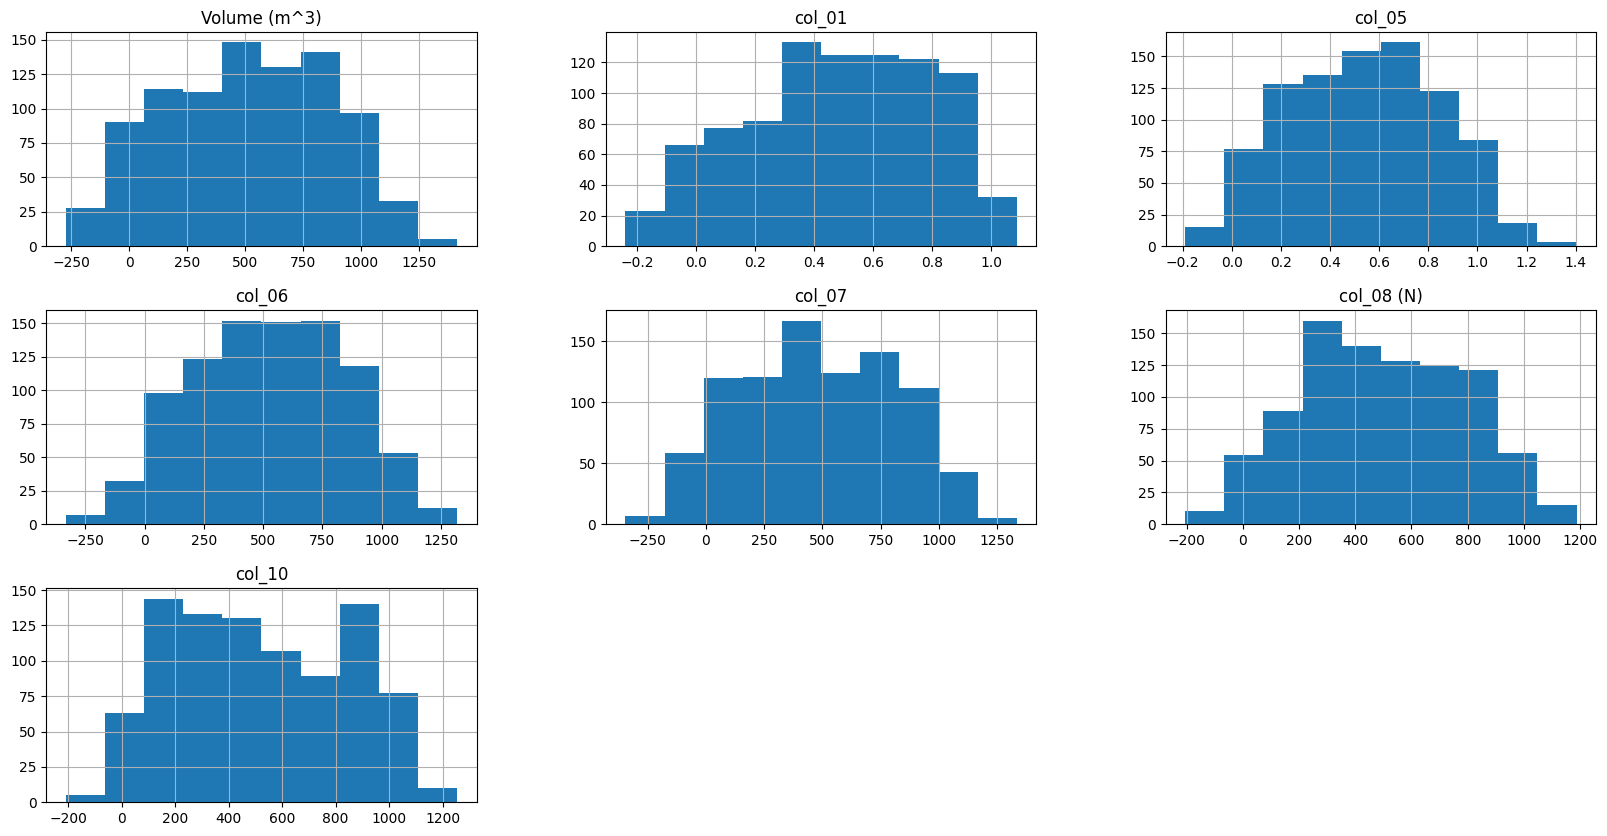

In [246]:
unique_data.hist(column=['Volume (m^3)', 'col_01', 'col_05', 'col_06',
                         'col_07', 'col_08 (N)', 'col_10'], figsize=(20, 10))

I looked for any outliers in the data, defining an outlier as a data point that is over 2 standard deviations from the mean.

In [247]:
def find_outliers(frame, deviations, label_column_name, ignore_columns = []):
    result = {}
    for col in frame.columns:
        if col not in ignore_columns:
            outliers = []
            if numpy.issubdtype(frame[col].dtype, numpy.number):
                std = frame[col].std(skipna=True)
                mean = frame[col].mean(skipna=True)
                upper = mean + (deviations * std)
                lower = mean - (deviations * std)
                for row, data in enumerate(frame[col]):
                    if data is not numpy.nan:
                        if (data > upper) or (data < lower):
                            outliers.append((frame.at[row, label_column_name], data))
            if len(outliers) > 0:
                result[col] = outliers
    return result

print("Outliers found in our data:")
find_outliers(unique_data, 2.0, 'Unique_ID', ['Location 1', 'Location 2', 'Person 1', 'Person 2'])


Outliers found in our data:


{'Volume (m^3)': [(np.int64(90), -197),
  (np.int64(103), -269),
  (np.int64(262), -198),
  (np.int64(286), -273),
  (np.int64(384), -213),
  (np.int64(391), 1252),
  (np.int64(412), -258),
  (np.int64(489), 1269),
  (np.int64(528), 1307),
  (np.int64(571), -215),
  (np.int64(605), -254),
  (np.int64(616), -233),
  (np.int64(680), -266),
  (np.int64(798), 1412),
  (np.int64(823), 1274)],
 'col_01': [(np.int64(6), -0.2072),
  (np.int64(11), -0.1681),
  (np.int64(82), -0.1605),
  (np.int64(122), -0.1883),
  (np.int64(184), -0.1522),
  (np.int64(335), -0.1787),
  (np.int64(367), -0.1618),
  (np.int64(439), -0.1404),
  (np.int64(470), -0.2059),
  (np.int64(647), -0.2402),
  (np.int64(649), -0.1472),
  (np.int64(867), -0.2381)],
 'col_05': [(np.int64(38), 1.1581),
  (np.int64(58), -0.1309),
  (np.int64(78), 1.166),
  (np.int64(95), -0.1661),
  (np.int64(109), 1.3008),
  (np.int64(153), 1.2715),
  (np.int64(285), 1.2001),
  (np.int64(305), -0.0918),
  (np.int64(351), 1.4032),
  (np.int64(373

I looked for a possible correlation between Volume and the ambiguous 8th column.

<Axes: xlabel='Volume (m^3)', ylabel='col_08 (N)'>

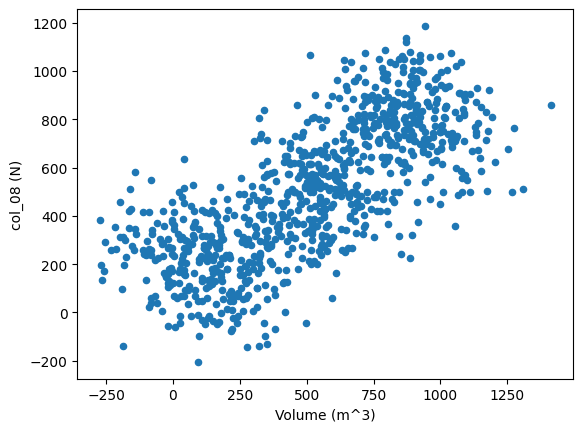

In [248]:
def prep_scatter(frame, x_column, y_column, x_label, y_label):
    scatter_data = {x_label: frame[x_column], y_label: frame[y_column]}
    df = pandas.DataFrame(scatter_data)
    return df

scatter_frame = prep_scatter(unique_data, 'Volume (m^3)',
                             'col_08 (N)', 'Volume (m^3)', 'col_08 (N)')
scatter_frame.plot.scatter(x = 0, y = 1)

Modeling

In [249]:
def create_classifiers():
    log_regress = LogisticRegression(max_iter=600, random_state=40)
    knn = KNeighborsClassifier(n_neighbors=30)
    dtree = DecisionTreeClassifier(max_depth=7, random_state=40)

    return [log_regress, knn, dtree]

my_classifiers = create_classifiers()
my_classifiers

[LogisticRegression(max_iter=600, random_state=40),
 KNeighborsClassifier(n_neighbors=30),
 DecisionTreeClassifier(max_depth=7, random_state=40)]

In [250]:
def cross_fold_validation(classifier, frame, folds):
    x = frame.copy(deep=True)
    x = x.dropna()
    x.pop(frame.columns[4])
    
    x.pop(frame.columns[5])
    x.pop(frame.columns[6])
    x.pop(frame.columns[11])

    ylabel = x.pop('label')
    estimator = make_pipeline(StandardScaler(), classifier)
    score = cross_val_score(estimator, X = x, y = ylabel, cv=folds, n_jobs=1)
    return score.tolist()
    
my_classifiers_scores = []
for classifier in my_classifiers:
    accuracy_scores = cross_fold_validation(classifier, unique_data, 5)
    my_classifiers_scores.append(accuracy_scores)
    print("Classifier: %s, Accuracy: %s." % (type(classifier).__name__, accuracy_scores))

print(my_classifiers_scores)

for c in my_classifiers_scores:
    sum = 0
    for acc in c:
        sum += acc
    print("Mean Score:", sum / len(c))

for i in range(len(my_classifiers_scores)):
    print("STD:", numpy.std(my_classifiers_scores[i]))

Classifier: LogisticRegression, Accuracy: [0.9943181818181818, 0.9886363636363636, 1.0, 1.0, 0.9828571428571429].
Classifier: KNeighborsClassifier, Accuracy: [1.0, 0.9943181818181818, 1.0, 1.0, 0.9828571428571429].
Classifier: DecisionTreeClassifier, Accuracy: [0.9431818181818182, 0.9488636363636364, 0.96, 0.9714285714285714, 0.9542857142857143].
[[0.9943181818181818, 0.9886363636363636, 1.0, 1.0, 0.9828571428571429], [1.0, 0.9943181818181818, 1.0, 1.0, 0.9828571428571429], [0.9431818181818182, 0.9488636363636364, 0.96, 0.9714285714285714, 0.9542857142857143]]
Mean Score: 0.9931623376623376
Mean Score: 0.995435064935065
Mean Score: 0.9555519480519481
STD: 0.006656195746177783
STD: 0.006662843959395702
STD: 0.009707824783857065


In [251]:
def significance_test(a_values, b_values, p_value):
    t, output_pval = scipy.stats.ttest_ind(a_values, b_values)
    return output_pval < p_value

for i in range(len(my_classifiers)):
    for j in range(i + 1, len(my_classifiers)):
        significant = significance_test(my_classifiers_scores[i], my_classifiers_scores[j], 0.10)
        print("%s vs %s: %s" % (type(my_classifiers[i]).__name__,
                                type(my_classifiers[j]).__name__, significant))

LogisticRegression vs KNeighborsClassifier: False
LogisticRegression vs DecisionTreeClassifier: True
KNeighborsClassifier vs DecisionTreeClassifier: True
